In [1]:
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm
from loguru import logger
from matplotlib import pyplot as plt
from source.utils.file_read import process_and_concat_files 
from source.utils.file_read import filter_df
from source.utils.generate_timestamp import generate_timestamps
from source.forecasters.deterministic import create_day_ahead_predictions, create_day_ahead_11_predictions, create_week_ahead_predictions
from source.forecasters.probabilistic import create_day_ahead_quantiles10, create_day_ahead_11_quantiles10, create_week_ahead_quantiles10
from source.forecasters.probabilistic import create_day_ahead_quantiles90, create_day_ahead_11_quantiles90, create_week_ahead_quantiles90
from source.utils.data_preprocess import normalize_dataframe, differentiate_dataframe
from source.ensemble.stack_generalization.feature_engineering.data_augmentation import create_augmented_dataframe
from source.ensemble.stack_generalization.data_preparation.data_train_test import prepare_train_test_data, get_numpy_Xy_train_test
from source.ensemble.stack_generalization.ensemble_model import run_ensemble_predictions_per_quantile, run_ensemble_variability_predictions
from source.ensemble.stack_generalization.second_stage.create_data_second_stage import create_2stage_dataframe, create_augmented_dataframe_2stage, create_var_ensemble_dataframe
from source.ensemble.stack_generalization.utils.results import collect_quantile_ensemble_predictions, create_ensemble_dataframe
from source.ensemble.stack_generalization.utils.display_results import display_forecasting_metrics
from source.ensemble.combination_scheme.equal_weights import calculate_equal_weights
from source.ensemble.combination_scheme.avg_weights import calculate_weighted_avg
from source.ensemble.utils.metrics import calculate_rmse, calculate_pinball_losses
from source.plots.plot_forecasts import plot_ensemble_forecasts, plot_var_ensemble_forecasts, plot_ramp_events, plot_weighted_avg_forecasts, plot_baseline_forecasts
from source.plots.plot_hypothesis_testing import plot_statistical_comparison, transform_loss_lists_to_df
from source.ensemble.stack_generalization.test_importance.first_stage_importance import first_stage_permutation_importance
from source.ensemble.stack_generalization.test_importance.second_stage_importance import second_stage_permutation_importance
from source.ensemble.stack_generalization.test_importance.plot_permutation_importance import plot_normalized_contributions
from source.ensemble.combination_scheme.weight_avg_plot_importance import plot_weight_avg_contributions
from sklearn.utils.fixes import parse_version, sp_version
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [2]:
from config.simulation_setting import Simulation, WeightedAvg, Stack

sim_params = Simulation.testing_period
weight_avg_params = WeightedAvg.params
ens_params = Stack.params

Testing Days:   0%|          | 0/80 [00:00<?, ?it/s]2024-06-14 16:46:04.091 | INFO     | __main__:<module>:66 -  
2024-06-14 16:46:04.091 | INFO     | __main__:<module>:67 - -------------------------------------------------------------------------------------------
2024-06-14 16:46:04.092 | INFO     | __main__:<module>:68 - Start prediction: 2023-03-26 00:00:00+00:00 - End prediction: 2023-03-27 00:00:00+00:00
2024-06-14 16:46:04.094 | INFO     | __main__:<module>:73 -  
2024-06-14 16:46:04.094 | INFO     | __main__:<module>:74 -  -----------------> Forecasters prediction submitted 
2024-06-14 16:46:04.312 | INFO     | __main__:<module>:113 -    
2024-06-14 16:46:04.313 | INFO     | __main__:<module>:114 -  PREDICO PLATFORM ML ENGINE  
2024-06-14 16:46:04.313 | INFO     | __main__:<module>:115 -    
2024-06-14 16:46:04.314 | INFO     | __main__:<module>:116 -  Collecting forecasters prediction for ensemble learning - model: LR  
2024-06-14 16:46:04.314 | INFO     | __main__:<module>:11

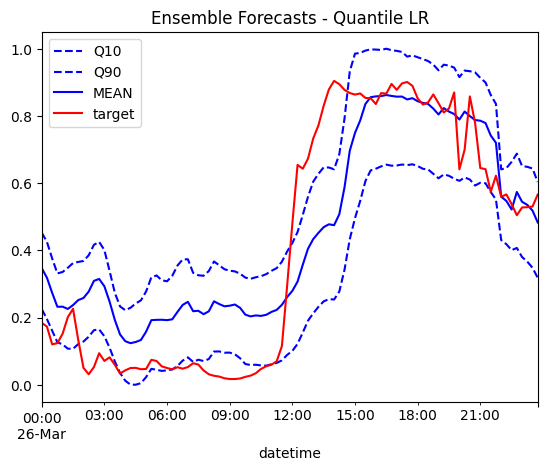

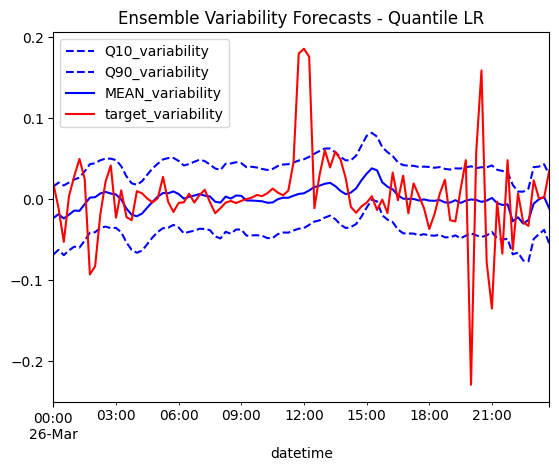

2024-06-14 16:46:11.505 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-14 16:46:11.506 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-14 16:46:11.506 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-14 16:46:11.506 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 0.167
2024-06-14 16:46:11.507 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 0.175
2024-06-14 16:46:11.507 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 0.208
2024-06-14 16:46:11.507 | INFO     | source.ensemble.s

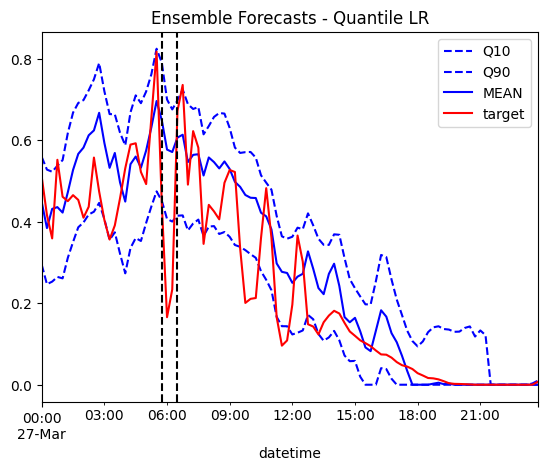

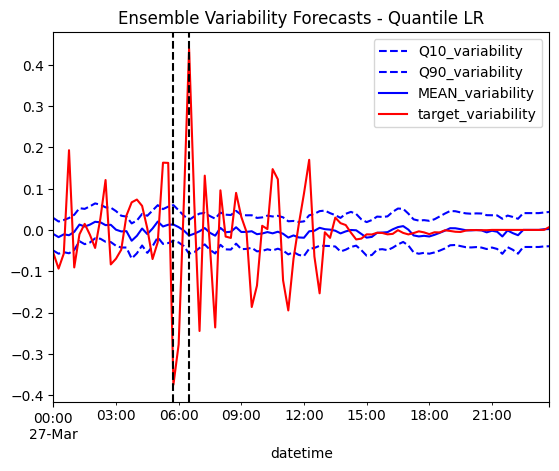

2024-06-14 16:46:13.255 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-14 16:46:13.255 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-14 16:46:13.255 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-14 16:46:13.256 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 0.11
2024-06-14 16:46:13.256 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 0.18
2024-06-14 16:46:13.256 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 0.184
2024-06-14 16:46:13.256 | INFO     | source.ensemble.sta

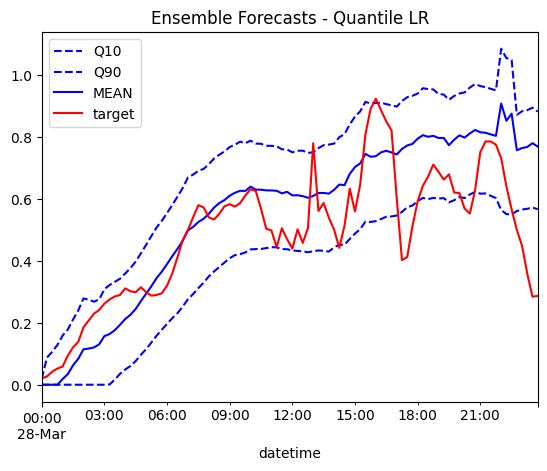

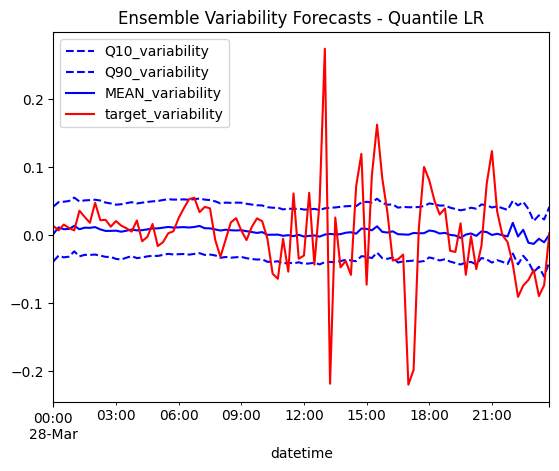

2024-06-14 16:46:15.071 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-14 16:46:15.071 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-14 16:46:15.071 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-14 16:46:15.072 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 0.154
2024-06-14 16:46:15.072 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 0.189
2024-06-14 16:46:15.072 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 0.193
2024-06-14 16:46:15.072 | INFO     | source.ensemble.s

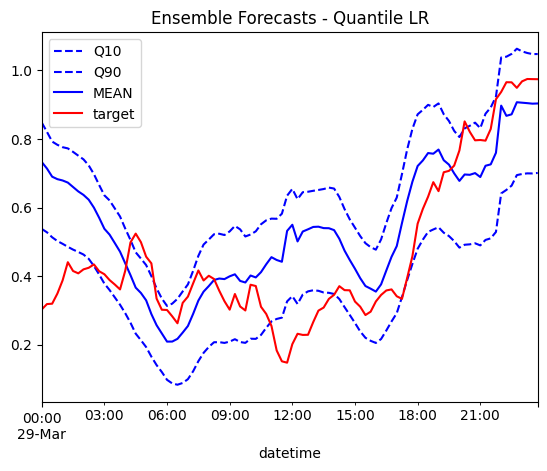

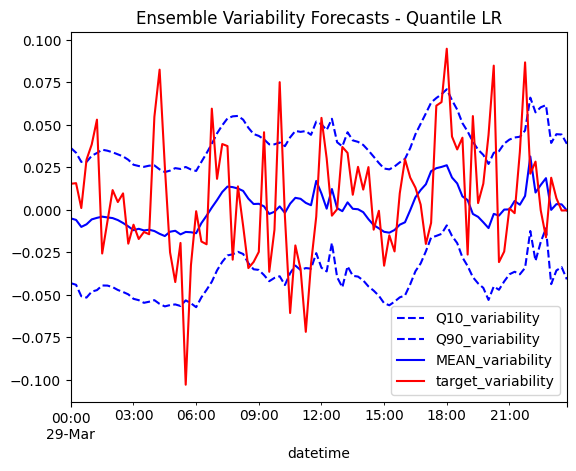

2024-06-14 16:46:16.864 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-14 16:46:16.865 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-14 16:46:16.865 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-14 16:46:16.865 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 0.169
2024-06-14 16:46:16.866 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 0.197
2024-06-14 16:46:16.866 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 0.167
2024-06-14 16:46:16.866 | INFO     | source.ensemble.s

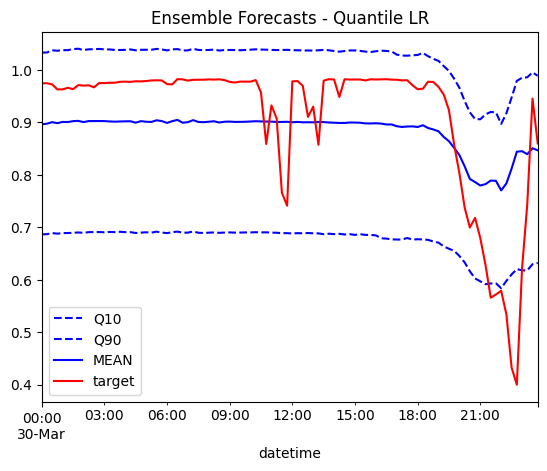

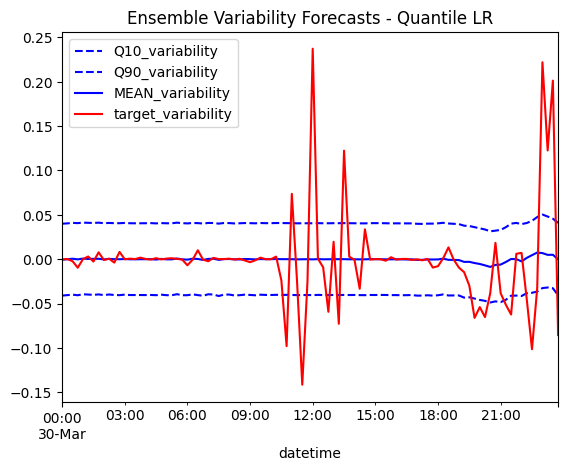

2024-06-14 16:46:18.580 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-14 16:46:18.581 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-14 16:46:18.581 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-14 16:46:18.582 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 0.108
2024-06-14 16:46:18.582 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 0.116
2024-06-14 16:46:18.582 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 0.117
2024-06-14 16:46:18.582 | INFO     | source.ensemble.s

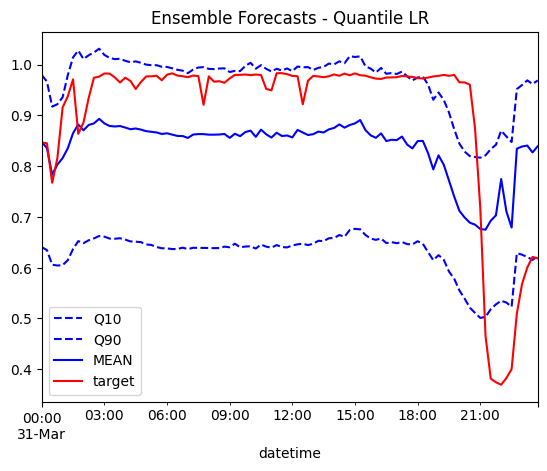

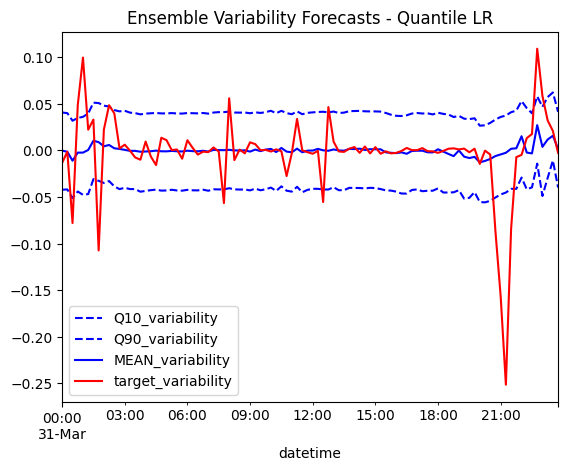

2024-06-14 16:46:20.371 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-14 16:46:20.372 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-14 16:46:20.372 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-14 16:46:20.372 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 0.151
2024-06-14 16:46:20.373 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 0.147
2024-06-14 16:46:20.373 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 0.16
2024-06-14 16:46:20.373 | INFO     | source.ensemble.st

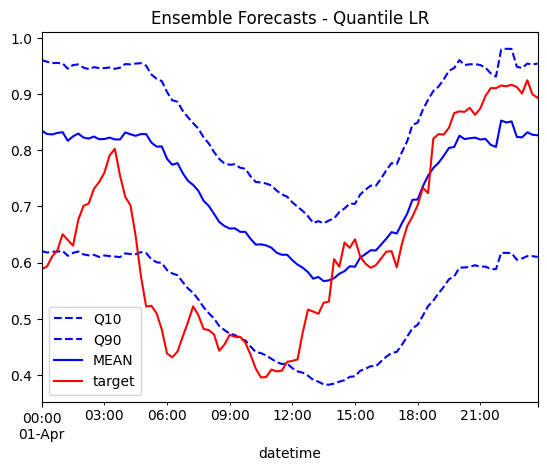

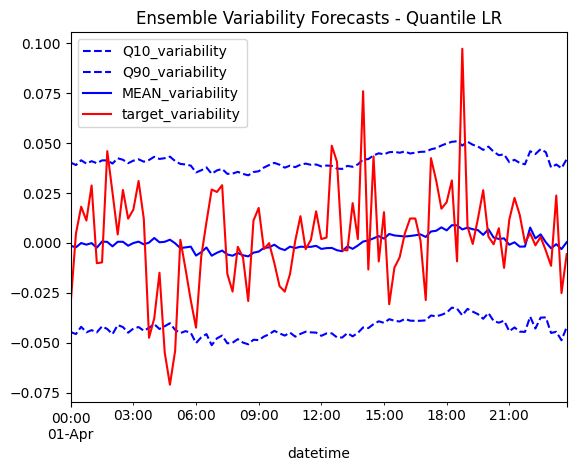

2024-06-14 16:46:22.099 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-14 16:46:22.100 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-14 16:46:22.100 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-14 16:46:22.100 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 0.16
2024-06-14 16:46:22.101 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 0.174
2024-06-14 16:46:22.101 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 0.169
2024-06-14 16:46:22.101 | INFO     | source.ensemble.st

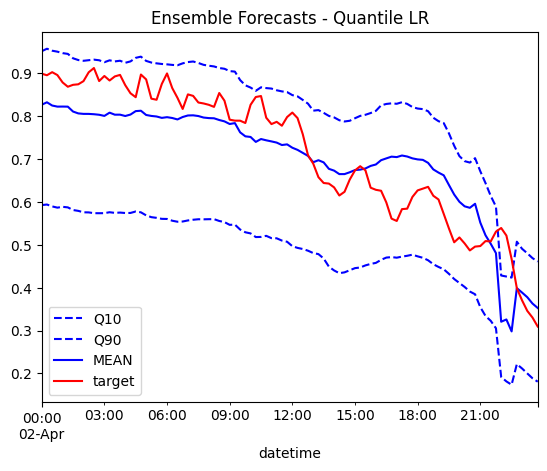

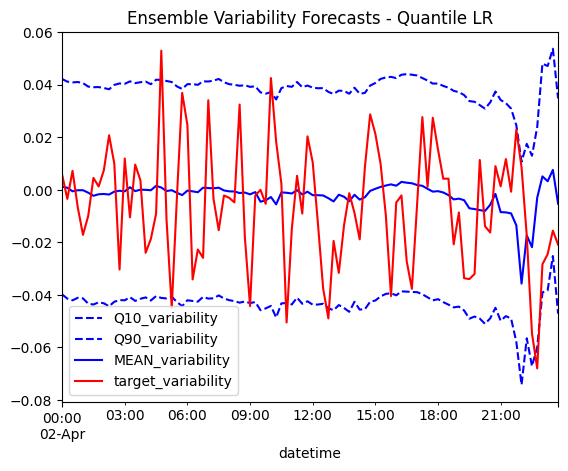

2024-06-14 16:46:23.873 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:12 -  
2024-06-14 16:46:23.874 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:13 - ------------- Wind Power Forecasting ------------------------------
2024-06-14 16:46:23.874 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:14 - ----------------- RMSE -----------------
2024-06-14 16:46:23.874 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:15 - GBR Stacked 0.075
2024-06-14 16:46:23.875 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:16 - Weighted Average 0.083
2024-06-14 16:46:23.875 | INFO     | source.ensemble.stack_generalization.utils.display_results:display_forecasting_metrics:17 - Equal Weights 0.077
2024-06-14 16:46:23.875 | INFO     | source.ensemble.s

KeyboardInterrupt: 

In [3]:
# set random seed
np.random.seed(42)

files = [sim_params['file_0'], sim_params['file_1'], sim_params['file_2'], sim_params['file_3'], sim_params['file_4']]
df = process_and_concat_files(files)

# get the maximum capacity
maximum_capacity = df.measured.max()

df_filtered = filter_df(df, sim_params['forecasts_col'], sim_params['measured_col'])

# loss quantile gradient boosting regressor
lst_rmse_gbr_ensemble = []
# loss equal weights scheme
lst_rmse_equal_weights = []
# loss weighted average scheme
lst_rmse_weighted_avg = []
# loss baseline day ahead
lst_rmse_baseline_dayahead = []
# loss baseline day ahead 11
lst_rmse_baseline_dayahead11h = []
# loss baseline week ahead
lst_rmse_baseline_week_ahead = []


if not ens_params['compute_abs_difference']:
    
    # loss var gradient boosting regressor
    lst_rmse_var_gbr_ensemble = []
    # loss var equal weights scheme
    lst_rmse_var_equal_weights = []
    # loss var weighted average scheme
    lst_rmse_var_weighted_avg = []
    # loss var baseline day ahead
    lst_rmse_var_baseline_dayahead = []
    # loss var baseline day ahead 11
    lst_rmse_var_baseline_dayahead11h = []
    # loss var baseline week ahead
    lst_rmse_var_baseline_week_ahead = []

    # loss quantile gradient boosting regressor
    lst_pb_gbr_ensemble_q10 = []
    lst_pb_gbr_ensemble_q90 = []
    # loss equal weights scheme
    lst_pb_weighted_avg_q10 = []
    lst_pb_weighted_avg_q90 = []
    # loss weighted average scheme
    lst_pb_equal_weights_q10 = []
    lst_pb_equal_weights_q90 = []
    # loss baseline day ahead
    lst_pb_dayahead_q10 = []
    lst_pb_dayahead_q90  = []
    # loss baseline day ahead 11
    lst_pb_dayahead_11h_q10 = []
    lst_pb_dayahead_11h_q90 = []
    # loss baseline week ahead
    lst_pb_week_ahead_q10 = []
    lst_pb_week_ahead_q90 = []

# loop over test days
for i in tqdm(range(sim_params['num_test_days']), desc='Testing Days'):

    # generate timestamps train and prediction
    start_training_timestamp, end_training_timestamp, start_prediction_timestamp, end_prediction_timestamp = generate_timestamps(sim_params['start_training'], i, sim_params['window_size'])

    logger.info(' ')
    logger.opt(colors = True).info('<blue>-------------------------------------------------------------------------------------------</blue>')
    logger.opt(colors = True).info(f'<blue>Start prediction: {start_prediction_timestamp} - End prediction: {end_prediction_timestamp}</blue>')

    df_train = df_filtered[df_filtered.index.to_series().between(start_training_timestamp, end_training_timestamp)].iloc[:-1,:]
    df_test = df_filtered[df_filtered.index.to_series().between(start_prediction_timestamp, end_prediction_timestamp)].iloc[:-1,:]

    logger.info(' ')
    logger.opt(colors = True).info('<blue> -----------------> Forecasters prediction submitted </blue>')
    
    # forecaster - day ahead forecast
    df_day_ahead_pred_train = create_day_ahead_predictions(df_train)
    df_day_ahead_pred_test = create_day_ahead_predictions(df_test)

    # forecaster - day ahead 11 forecast
    df_day_ahead11_pred_train = create_day_ahead_11_predictions(df_train)
    df_day_ahead11_pred_test = create_day_ahead_11_predictions(df_test)

    # forecaster - week ahead forecast
    df_week_ahead_pred_train = create_week_ahead_predictions(df_train)
    df_week_ahead_pred_test = create_week_ahead_predictions(df_test)

    # forecaster - day ahead quantile-10
    df_day_ahead_q10_train = create_day_ahead_quantiles10(df_train)
    df_day_ahead_q10_test = create_day_ahead_quantiles10(df_test)

    # forecaster - day ahead 11 quantile-10
    df_day_ahead11_q10_train = create_day_ahead_11_quantiles10(df_train)
    df_day_ahead11_q10_test = create_day_ahead_11_quantiles10(df_test)

    # forecaster - week ahead quantile-10
    df_week_ahead_q10_train = create_week_ahead_quantiles10(df_train)
    df_week_ahead_q10_test = create_week_ahead_quantiles10(df_test)

    # forecaster - day ahead quantile-90
    df_day_ahead_q90_train = create_day_ahead_quantiles90(df_train)
    df_day_ahead_q90_test = create_day_ahead_quantiles90(df_test)

    # forecaster - day ahead 11 quantile-90
    df_day_ahead11_q90_train = create_day_ahead_11_quantiles90(df_train)
    df_day_ahead11_q90_test = create_day_ahead_11_quantiles90(df_test)

    # forecaster - week ahead quantile-90
    df_week_ahead_q90_train = create_week_ahead_quantiles90(df_train)
    df_week_ahead_q90_test = create_week_ahead_quantiles90(df_test)

    # ML ENGINE PREDICO PLATFORM
    logger.info('   ')
    logger.opt(colors = True).info(f'<fg 250,128,114> PREDICO PLATFORM ML ENGINE </fg 250,128,114> ')
    logger.info('   ')
    logger.opt(colors = True).info(f'<fg 250,128,114> Collecting forecasters prediction for ensemble learning - model: {ens_params["model_type"]} </fg 250,128,114> ')
    
    logger.info('   ')
    logger.opt(colors=True).info(f'<fg 250,128,114> Forecasters Ensemble DataFrame </fg 250,128,114>')
    # make esemble dataframe 
    df_train_ensemble = pd.concat([df_day_ahead_pred_train, df_day_ahead11_pred_train, df_week_ahead_pred_train], axis=1) 
    df_test_ensemble = pd.concat([df_day_ahead_pred_test, df_day_ahead11_pred_test, df_week_ahead_pred_test], axis=1)
    df_ensemble = pd.concat([df_train_ensemble, df_test_ensemble], axis=0)

    if ens_params['add_quantile_predictions']:
        df_train_ensemble_quantile10 = pd.concat([df_day_ahead_q10_train, df_day_ahead11_q10_train, df_week_ahead_q10_train], axis=1)
        df_train_ensemble_quantile90 = pd.concat([df_day_ahead_q90_train, df_day_ahead11_q90_train, df_week_ahead_q90_train], axis=1)
        df_test_ensemble_quantile10 = pd.concat([df_day_ahead_q10_test, df_day_ahead11_q10_test, df_week_ahead_q10_test], axis=1)
        df_test_ensemble_quantile90 = pd.concat([df_day_ahead_q90_test, df_day_ahead11_q90_test, df_week_ahead_q90_test], axis=1)
        df_ensemble_quantile10 = pd.concat([df_train_ensemble_quantile10, df_test_ensemble_quantile10], axis=0)
        df_ensemble_quantile90 = pd.concat([df_train_ensemble_quantile90, df_test_ensemble_quantile90], axis=0)
    else:
        df_train_ensemble_quantile10, df_test_ensemble_quantile10 = None, None
        df_train_ensemble_quantile90, df_test_ensemble_quantile90 = None, None
        df_ensemble_quantile10, df_ensemble_quantile90 = None, None

    # normalize dataframe
    logger.info('   ')
    logger.opt(colors=True).info(f'<fg 250,128,114> Normalize DataFrame </fg 250,128,114>')
    df_ensemble_normalized = normalize_dataframe(df_ensemble, maximum_capacity)
    if ens_params['add_quantile_predictions']:  # normalize quantile predictions
        logger.opt(colors=True).info(f'<fg 250,128,114> -- add quantile predictions </fg 250,128,114>')
        df_ensemble_normalized_quantile10 = normalize_dataframe(df_ensemble_quantile10, maximum_capacity)
        df_ensemble_normalized_quantile90 = normalize_dataframe(df_ensemble_quantile90, maximum_capacity)
    else:
        df_ensemble_normalized_quantile10, df_ensemble_normalized_quantile90 = None, None

    # augment dataframe
    logger.info('   ')
    logger.opt(colors=True).info(f'<fg 250,128,114> Augment DataFrame </fg 250,128,114>')
    df_ensemble_normalized_lag = create_augmented_dataframe(df_ensemble_normalized, 
                                                            max_lags=ens_params['max_lags'], 
                                                            forecasters_diversity=ens_params['forecasters_diversity'], 
                                                            lagged=ens_params['lagged'], 
                                                            augmented=ens_params['augment'],
                                                            differenciate=ens_params['differenciate'])
    if ens_params['add_quantile_predictions']:  # augment quantile predictions
        logger.opt(colors=True).info(f'<fg 250,128,114> -- augment quantile predictions </fg 250,128,114>')
        df_ensemble_normalized_lag_quantile10 = create_augmented_dataframe(df_ensemble_normalized_quantile10,
                                                                            max_lags=ens_params['max_lags'], 
                                                                            forecasters_diversity=ens_params['forecasters_diversity'], 
                                                                            lagged=ens_params['lagged'], 
                                                                            augmented=ens_params['augment'], differenciate=ens_params['differenciate'])
        df_ensemble_normalized_lag_quantile90 = create_augmented_dataframe(df_ensemble_normalized_quantile90, 
                                                                        max_lags=ens_params['max_lags'], 
                                                                        forecasters_diversity=ens_params['forecasters_diversity'], 
                                                                        lagged=ens_params['lagged'], 
                                                                        augmented=ens_params['augment'], 
                                                                        differenciate=ens_params['differenciate'])
    else:
        df_ensemble_normalized_lag_quantile10, df_ensemble_normalized_lag_quantile90 = None, None

    # concatenate train and test dataframes
    df_process = pd.concat([df_train, df_test], axis=0)

    # normalize dataframe
    df_process_norm = normalize_dataframe(df_process, maximum_capacity)

    # differenciate dataframe
    if ens_params['compute_abs_difference']:
        df_process_norm_diff = differentiate_dataframe(df_process_norm)
    else:
        df_process_norm_diff = df_process_norm.copy()
        lst_cols_diff = ['diff_' + name for name in list(df_process_norm.columns)]
        df_process_norm_diff.columns = lst_cols_diff

    df_train_norm_diff, df_test_norm_diff = df_process_norm_diff[df_process_norm_diff.index < start_prediction_timestamp], df_process_norm_diff[df_process_norm_diff.index >= start_prediction_timestamp]
    df_train_ensemble, df_test_ensemble = prepare_train_test_data(df_ensemble_normalized_lag, df_train_norm_diff, df_test_norm_diff, start_prediction_timestamp, ens_params['max_lags'])

    if ens_params['add_quantile_predictions']:
        df_train_ensemble_quantile10, df_test_ensemble_quantile10 = df_ensemble_normalized_lag_quantile10[df_ensemble_normalized_lag_quantile10.index< start_prediction_timestamp], df_ensemble_normalized_lag_quantile10[df_ensemble_normalized_lag_quantile10.index>= start_prediction_timestamp]
        df_train_ensemble_quantile90, df_test_ensemble_quantile90 = df_ensemble_normalized_lag_quantile90[df_ensemble_normalized_lag_quantile90.index< start_prediction_timestamp], df_ensemble_normalized_lag_quantile90[df_ensemble_normalized_lag_quantile90.index>= start_prediction_timestamp]
    else:
        df_train_ensemble_quantile10, df_test_ensemble_quantile10 = None, None
        df_train_ensemble_quantile90, df_test_ensemble_quantile90 = None, None

    df_dayahead = df_test_norm_diff[['diff_norm_dayaheadforecast', 'diff_norm_dayaheadconfidence10', 'diff_norm_dayaheadconfidence90', 'diff_norm_measured']]
    if ens_params['plot_baseline']:
        plot_baseline_forecasts(df_dayahead, model_name='Day-Ahead Model')

    df_dayahead11h = df_test_norm_diff[['diff_norm_dayahead11hforecast', 'diff_norm_dayahead11hconfidence10', 'diff_norm_dayahead11hconfidence90', 'diff_norm_measured']]
    if ens_params['plot_baseline']:
        plot_baseline_forecasts(df_dayahead11h, model_name='Day-Ahead-11h Model')

    df_weekahead = df_test_norm_diff[['diff_norm_weekaheadforecast', 'diff_norm_weekaheadconfidence10', 'diff_norm_weekaheadconfidence90', 'diff_norm_measured']]
    if ens_params['plot_baseline']:
        plot_baseline_forecasts(df_weekahead, model_name='Week-Ahead Model')

    # assert df_test match df_ensemble_test
    assert (df_test_norm_diff['diff_norm_measured'] == df_test_ensemble['diff_norm_targ']).all()

    # make X-y train and test sets
    X_train, y_train, X_test, y_test = get_numpy_Xy_train_test(df_train_ensemble, df_test_ensemble)

    if ens_params['add_quantile_predictions']:
        X_train_quantile10, X_test_quantile10 = df_train_ensemble_quantile10.values, df_test_ensemble_quantile10.values
        X_train_quantile90, X_test_quantile90 = df_train_ensemble_quantile90.values, df_test_ensemble_quantile90.values
    else:
        X_train_quantile10, X_test_quantile10 = None, None
        X_train_quantile90, X_test_quantile90 = None, None

    # assert do not have nans (should do it before in processing file)
    assert df_train_ensemble.isna().sum().sum() == 0

    # run ensemble learning
    logger.info('   ')
    logger.opt(colors=True).info(f'<fg 250,128,114> Compute Ensemble Predictions </fg 250,128,114>')
    predictions = {}
    if i==0:
        best_results = {}
    for quantile in tqdm(ens_params['quantiles'], desc='Quantile Regression'):

        # run ensemble predictions
        predictions, best_results, fitted_model, X_train_augmented, X_test_augmented, df_train_ensemble_augmented = run_ensemble_predictions_per_quantile(abs_differenciate=ens_params['compute_abs_difference'], 
                                                                                                                                                            X_train=X_train, X_test=X_test, y_train=y_train, df_train_ensemble=df_train_ensemble, 
                                                                                                                                                            predictions=predictions, quantile=quantile, add_quantiles=ens_params['add_quantile_predictions'], 
                                                                                                                                                            augment_q50=ens_params['augment_q50'], nr_cv_splits=ens_params['nr_cv_splits'], model_type=ens_params['model_type'], solver=solver, 
                                                                                                                                                            gbr_update_every_days=ens_params['gbr_update_every_days'], gbr_config_params=ens_params['gbr_config_params'], 
                                                                                                                                                            lr_config_params=ens_params['lr_config_params'], plot_importance_gbr=ens_params['plot_importance_gbr'], 
                                                                                                                                                            best_results=best_results, iteration=i,
                                                                                                                                                            X_train_quantile10=X_train_quantile10, X_test_quantile10=X_test_quantile10, df_train_ensemble_quantile10=df_train_ensemble_quantile10, 
                                                                                                                                                            X_train_quantile90=X_train_quantile90, X_test_quantile90=X_test_quantile90, df_train_ensemble_quantile90=df_train_ensemble_quantile90)
        if ens_params['plot_importance_permutation_first_stage']:
            logger.info('   ')
            logger.opt(colors=True).info(f'<fg 250,128,114> EX-Post Payments with loss-based importance </fg 250,128,114>')
            resultsdf = first_stage_permutation_importance(ens_params['nr_permutations'], quantile, fitted_model, X_test_augmented, y_test, df_train_ensemble_augmented)
            plot_normalized_contributions(ens_params['nr_permutations'], quantile, resultsdf, stage='Wind Power')
            logger.info('   ')

        if not ens_params['compute_abs_difference']:
            if ens_params['compute_second_stage'] and quantile == 0.5:
                logger.info('   ')
                logger.opt(colors=True).info(f'<fg 72,201,176> Compute Variability Predictions </fg 72,201,176>')
                # make predictions for variability
                predictions_insample = fitted_model.predict(X_train_augmented)
                predictions_outsample = fitted_model.predict(X_test_augmented)
                # create 2-stage dataframe
                df_2stage = create_2stage_dataframe(df_train_ensemble, df_test_ensemble, y_train, y_test, predictions_insample, predictions_outsample)
                # differenciate dataframe with lags
                df_2stage_process = create_augmented_dataframe_2stage(df_2stage, 
                                                                    ens_params['order_diff'], 
                                                                    max_lags=ens_params['max_lags_var'], 
                                                                    augment=ens_params['augment_var'])
                # split train and test
                df_2stage_train, df_2stage_test = df_2stage_process[df_2stage_process.index < start_prediction_timestamp], df_2stage_process[df_2stage_process.index >= start_prediction_timestamp]
                # make X-y train and test sets for 2-stage model
                X_train_2stage, y_train_2stage, X_test_2stage, y_test_2stage = df_2stage_train.drop(columns=['targets']).values, df_2stage_train['targets'].values, df_2stage_test.drop(columns=['targets']).values, df_2stage_test['targets'].values
                # run ensemble learning
                variability_predictions = {}
                if i == 0:
                    best_results_var = {}
                # run variability predictions
                for quantile in tqdm(ens_params['quantiles'], desc='Quantile Regression'):
                    variability_predictions, best_results_var, var_fitted_model = run_ensemble_variability_predictions(X_train_2stage = X_train_2stage, y_train_2stage=y_train_2stage, X_test_2stage=X_test_2stage,
                                                                                                                    variability_predictions=variability_predictions, 
                                                                                                                    quantile=quantile, nr_cv_splits=ens_params['nr_cv_splits'], 
                                                                                                                    var_model_type=ens_params['var_model_type'], 
                                                                                                                    solver=solver, 
                                                                                                                    var_gbr_config_params=ens_params['var_gbr_config_params'], 
                                                                                                                    var_lr_config_params=ens_params['var_lr_config_params'], 
                                                                                                                    gbr_update_every_days=ens_params['gbr_update_every_days'], 
                                                                                                                    iteration=i, best_results_var=best_results_var)
                    
                    if ens_params['plot_importance_permutation_first_stage']:
                        resultsdf = second_stage_permutation_importance(ens_params['nr_permutations'],
                                                                        quantile, var_fitted_model, fitted_model, X_test_augmented, y_test, df_train_ensemble_augmented,
                                                                        X_train_augmented, df_train_ensemble, df_test_ensemble, y_train, 
                                                                        ens_params['order_diff'], 
                                                                        ens_params['max_lags_var'], 
                                                                        ens_params['augment_var'], 
                                                                        start_prediction_timestamp)
                        plot_normalized_contributions(ens_params['nr_permutations'], 
                                                    quantile, resultsdf, stage='Wind Power Variability')

                # collect results as dictionary
                var_predictions_dict = collect_quantile_ensemble_predictions(quantiles=ens_params['quantiles'], 
                                                                            test_data=df_2stage_test, predictions=variability_predictions)
                df_var_ensemble = create_var_ensemble_dataframe(quantiles=ens_params['quantiles'], 
                                                                quantile_predictions_dict=var_predictions_dict, df_test=df_2stage_test)

        logger.info('   ')
        del X_train_augmented, X_test_augmented, df_train_ensemble_augmented
        gc.collect()

    # collect results as dictionary
    quantile_predictions_dict = collect_quantile_ensemble_predictions(quantiles=ens_params['quantiles'], 
                                                                    test_data=df_test_norm_diff, predictions=predictions)
    
    # collect results as dataframe
    df_pred_ensemble = create_ensemble_dataframe(ens_params['quantiles'],
                                                quantile_predictions_dict, df_test_norm_diff)

    # performance ensemble
    rmse_ensemble = round(calculate_rmse(df_pred_ensemble, '50_predictions').values[0][0], 3)
    lst_rmse_gbr_ensemble.append(rmse_ensemble)
    if not ens_params['compute_abs_difference']:
        pinball_ensemble = calculate_pinball_losses(df_pred_ensemble, '10_predictions', '90_predictions')
        pinball_ensemble_q10 = round(pinball_ensemble['pb_loss_10'].values[0], 3)
        pinball_ensemble_q90 = round(pinball_ensemble['pb_loss_90'].values[0], 3)
        lst_pb_gbr_ensemble_q10.append(pinball_ensemble_q10)
        lst_pb_gbr_ensemble_q90.append(pinball_ensemble_q90)

    if not ens_params['compute_abs_difference']:
        # performance variability ensemble
        rmse_var_ensemble = round(calculate_rmse(df_var_ensemble, '50_var_predictions', targ_col='targets').values[0][0], 3)
        lst_rmse_var_gbr_ensemble.append(rmse_var_ensemble)

        df_weighted_avg_var, dict_weights_var = calculate_weighted_avg(df_train_norm_diff, df_test_norm_diff, start_prediction_timestamp, window_size_valid=weight_avg_params['window_size_valid'], var=True)
        rmse_var_weighted_avg = round(calculate_rmse(df_weighted_avg_var, 'mean_prediction').values[0][0], 3)
        lst_rmse_var_weighted_avg.append(rmse_var_weighted_avg)

        # plot contribution weighted average
        if ens_params['plot_importance_weighted_avg']:
            plot_weight_avg_contributions(dict_weights_var, quantile=0.5, stage='Wind Power Variability', days= weight_avg_params['window_size_valid'])

        # concatenate last training row with test data
        df_test_norm_var = pd.concat([df_train_norm_diff.iloc[-1:, :], df_test_norm_diff], axis=0).diff().iloc[1:, :]

        df_equal_weights_var = calculate_equal_weights(df_test_norm_var)
        rmse_var_equal_weights = round(calculate_rmse(df_equal_weights_var, 'mean_prediction').values[0][0], 3)
        lst_rmse_var_equal_weights.append(rmse_var_equal_weights)

        df_dayahead_var = df_test_norm_var[['diff_norm_dayaheadforecast', 'diff_norm_measured']]
        rmse_var_dayahead = round(calculate_rmse(df_dayahead_var, 'diff_norm_dayaheadforecast').values[0][0], 3)
        lst_rmse_var_baseline_dayahead.append(rmse_var_dayahead)

        df_dayahead_11h_var = df_test_norm_var[['diff_norm_dayahead11hforecast', 'diff_norm_measured']]
        rmse_var_dayahead_11h = round(calculate_rmse(df_dayahead_11h_var, 'diff_norm_dayahead11hforecast').values[0][0], 3)
        lst_rmse_var_baseline_dayahead11h.append(rmse_var_dayahead_11h)

        # performance week ahead
        df_week_ahead_var = df_test_norm_var[['diff_norm_weekaheadforecast', 'diff_norm_measured']]
        rmse_var_week_ahead = round(calculate_rmse(df_week_ahead_var, 'diff_norm_weekaheadforecast').values[0][0], 3)
        lst_rmse_var_baseline_week_ahead.append(rmse_var_week_ahead)

    # performance weighted average
    df_weighted_avg, dict_weights = calculate_weighted_avg(df_train_norm_diff, df_test_norm_diff, start_prediction_timestamp, window_size_valid=weight_avg_params['window_size_valid'])
    rmse_weighted_avg = round(calculate_rmse(df_weighted_avg, 'mean_prediction').values[0][0], 3)
    lst_rmse_weighted_avg.append(rmse_weighted_avg)
    if not ens_params['compute_abs_difference']:
        pinball_weighted_avg = calculate_pinball_losses(df_weighted_avg, 'Q10', 'Q90')
        pinball_weighted_avg_q10 = round(pinball_weighted_avg['pb_loss_10'].values[0], 3)
        pinball_weighted_avg_q90 = round(pinball_weighted_avg['pb_loss_90'].values[0], 3)
        lst_pb_weighted_avg_q10.append(pinball_weighted_avg_q10)
        lst_pb_weighted_avg_q90.append(pinball_weighted_avg_q90)
    
    # plot forecasts weighted avg
    if ens_params['plot_weighted_avg']:
        plot_weighted_avg_forecasts(df_weighted_avg)

    # plot contribution weighted average
    if ens_params['plot_importance_weighted_avg']:
        for quantile in ens_params['quantiles']:
            plot_weight_avg_contributions(dict_weights, quantile, stage='Wind Power', days = weight_avg_params['window_size_valid'])

    # performance equal weights
    df_equal_weights = calculate_equal_weights(df_test_norm_diff)
    rmse_equal_weights = round(calculate_rmse(df_equal_weights, 'mean_prediction').values[0][0], 3)
    lst_rmse_equal_weights.append(rmse_equal_weights)
    if not ens_params['compute_abs_difference']:
        pinball_equal_weights = calculate_pinball_losses(df_equal_weights, 'Q10', 'Q90')
        pinball_equal_weights_q10 = round(pinball_equal_weights['pb_loss_10'].values[0], 3)
        pinball_equal_weights_q90 = round(pinball_equal_weights['pb_loss_90'].values[0], 3)
        lst_pb_equal_weights_q10.append(pinball_equal_weights_q10)
        lst_pb_equal_weights_q90.append(pinball_equal_weights_q90)

    # performance day-ahead
    df_dayahead = df_test_norm_diff[['diff_norm_dayaheadforecast', 'diff_norm_dayaheadconfidence10', 'diff_norm_dayaheadconfidence90', 'diff_norm_measured']]
    rmse_dayahead = round(calculate_rmse(df_dayahead, 'diff_norm_dayaheadforecast').values[0][0], 3)
    lst_rmse_baseline_dayahead.append(rmse_dayahead)
    if not ens_params['compute_abs_difference']:
        pinball_dayahead = calculate_pinball_losses(df_dayahead, 'diff_norm_dayaheadconfidence10', 'diff_norm_dayaheadconfidence90')
        pinball_dayahead_q10 = round(pinball_dayahead['pb_loss_10'].values[0], 3)
        pinball_dayahead_q90 = round(pinball_dayahead['pb_loss_90'].values[0], 3)
        lst_pb_dayahead_q10.append(pinball_dayahead_q10)
        lst_pb_dayahead_q90.append(pinball_dayahead_q90)
    
    # performance day-ahead-11h
    df_dayahead_11h = df_test_norm_diff[['diff_norm_dayahead11hforecast', 'diff_norm_dayahead11hconfidence10', 'diff_norm_dayahead11hconfidence90', 'diff_norm_measured']]
    rmse_dayahead_11h = round(calculate_rmse(df_dayahead_11h, 'diff_norm_dayahead11hforecast').values[0][0], 3)
    lst_rmse_baseline_dayahead11h.append(rmse_dayahead_11h)
    if not ens_params['compute_abs_difference']:
        pinball_dayahead_11h = calculate_pinball_losses(df_dayahead_11h, 'diff_norm_dayahead11hconfidence10', 'diff_norm_dayahead11hconfidence90')
        pinball_dayahead_11h_q10 = round(pinball_dayahead_11h['pb_loss_10'].values[0], 3)
        pinball_dayahead_11h_q90 = round(pinball_dayahead_11h['pb_loss_90'].values[0], 3)
        lst_pb_dayahead_11h_q10.append(pinball_dayahead_11h_q10)
        lst_pb_dayahead_11h_q90.append(pinball_dayahead_11h_q90)

    # performance week ahead
    df_week_ahead = df_test_norm_diff[['diff_norm_weekaheadforecast', 'diff_norm_weekaheadconfidence10', 'diff_norm_weekaheadconfidence90', 'diff_norm_measured']]
    rmse_week_ahead = round(calculate_rmse(df_week_ahead, 'diff_norm_weekaheadforecast').values[0][0], 3)
    lst_rmse_baseline_week_ahead.append(rmse_week_ahead)
    if not ens_params['compute_abs_difference']:
        pinball_week_ahead = calculate_pinball_losses(df_week_ahead, 'diff_norm_weekaheadconfidence10', 'diff_norm_weekaheadconfidence90')
        pinball_week_ahead_q10 = round(pinball_week_ahead['pb_loss_10'].values[0], 3)
        pinball_week_ahead_q90 = round(pinball_week_ahead['pb_loss_90'].values[0], 3)
        lst_pb_week_ahead_q10.append(pinball_week_ahead_q10)
        lst_pb_week_ahead_q90.append(pinball_week_ahead_q90)

    # plot forecasts
    plot_ensemble_forecasts(df_pred_ensemble, df_test_ensemble)
    nr_previous_days = len(pd.date_range(start=start_training_timestamp, end=end_training_timestamp, freq='1D')) - 1
    plt.title(f'Ensemble Forecasts - Quantile {ens_params["model_type"]}')
    plot_ramp_events(df_test_norm_diff, ens_params['compute_abs_difference'])
    if not ens_params['zoom_in_variability']:  # zoom in the variability forecasts
        plt.ylim(-0.01, 1)
    plt.show()

    if not ens_params['compute_abs_difference']:
        # plot variability forecast results
        plot_var_ensemble_forecasts(df_var_ensemble, df_2stage_test)
        nr_previous_days = len(pd.date_range(start=start_training_timestamp, end=end_training_timestamp, freq='1D')) - 1
        plt.title(f'Ensemble Variability Forecasts - Quantile {ens_params["var_model_type"]}')
        plot_ramp_events(df_test_norm_diff, ens_params['compute_abs_difference'])
        if not ens_params['zoom_in_variability']:  # zoom in the variability forecasts
            plt.ylim(-0.6, 0.6)
        plt.show()

    if sim_params['display_metrics']:
        display_forecasting_metrics(ens_params=ens_params, 
                                    rmse_ensemble=rmse_ensemble, rmse_weighted_avg=rmse_weighted_avg, rmse_equal_weights=rmse_equal_weights,
                                    rmse_dayahead=rmse_dayahead, rmse_dayahead_11h=rmse_dayahead_11h, rmse_week_ahead=rmse_week_ahead,
                                    pinball_ensemble_q10=pinball_ensemble_q10, pinball_weighted_avg_q10=pinball_weighted_avg_q10, pinball_equal_weights_q10=pinball_equal_weights_q10,
                                    pinball_dayahead_q10=pinball_dayahead_q10, pinball_dayahead_11h_q10=pinball_dayahead_11h_q10, pinball_week_ahead_q10=pinball_week_ahead_q10,
                                    pinball_ensemble_q90=pinball_ensemble_q90, pinball_weighted_avg_q90=pinball_weighted_avg_q90, pinball_equal_weights_q90=pinball_equal_weights_q90,
                                    pinball_dayahead_q90=pinball_dayahead_q90, pinball_dayahead_11h_q90=pinball_dayahead_11h_q90, pinball_week_ahead_q90=pinball_week_ahead_q90,
                                    rmse_var_ensemble=rmse_var_ensemble, rmse_var_weighted_avg=rmse_var_weighted_avg, rmse_var_equal_weights=rmse_var_equal_weights,
                                    rmse_var_dayahead=rmse_var_dayahead, rmse_var_dayahead_11h=rmse_var_dayahead_11h, rmse_var_week_ahead=rmse_var_week_ahead)

In [ ]:
import scikit_posthocs as sp

data = transform_loss_lists_to_df(lst_rmse_gbr_ensemble, lst_rmse_equal_weights, lst_rmse_weighted_avg, lst_rmse_baseline_dayahead, lst_rmse_baseline_dayahead11h, lst_rmse_baseline_week_ahead)
avg_rank = data.groupby('days').rmse.rank(pct=True).groupby(data.model).mean()
pc = sp.posthoc_nemenyi_friedman(data, y_col='rmse', block_col='days', group_col='model', melted=True)
plot_statistical_comparison(pc, avg_rank,
                            title1 = 'RMSE-based Statistical Significance',
                            title2 = 'RMSE-based Statistical Comparison: critical difference diagram of ranks')

if not ens_params['compute_abs_difference']:

    data = transform_loss_lists_to_df(lst_pb_gbr_ensemble_q10, lst_pb_equal_weights_q10, lst_pb_weighted_avg_q10, lst_pb_dayahead_q10, lst_pb_dayahead_11h_q10, lst_pb_week_ahead_q10)
    avg_rank = data.groupby('days').rmse.rank(pct=True).groupby(data.model).mean()
    pc = sp.posthoc_nemenyi_friedman(data, y_col='rmse', block_col='days', group_col='model', melted=True)
    plot_statistical_comparison(pc, avg_rank,
                                title1 = 'Q10 Pinball loss-based Statistical Significance',
                                title2 = 'Q10 Pinball loss-based Statistical Comparison: critical difference diagram of ranks')
    
    data = transform_loss_lists_to_df(lst_pb_gbr_ensemble_q90, lst_pb_equal_weights_q90, lst_pb_weighted_avg_q90, lst_pb_dayahead_q90, lst_pb_dayahead_11h_q90, lst_pb_dayahead_11h_q90)
    avg_rank = data.groupby('days').rmse.rank(pct=True).groupby(data.model).mean()
    pc = sp.posthoc_nemenyi_friedman(data, y_col='rmse', block_col='days', group_col='model', melted=True)
    plot_statistical_comparison(pc, avg_rank,
                                title1 = 'Q90 Pinball loss-based Statistical Significance',
                                title2 = 'Q90 Pinball loss-based Statistical Comparison: critical difference diagram of ranks')
    
    data = transform_loss_lists_to_df(lst_rmse_var_gbr_ensemble, lst_rmse_var_equal_weights, lst_rmse_var_weighted_avg, lst_rmse_var_baseline_dayahead, lst_rmse_var_baseline_dayahead11h, lst_rmse_var_baseline_week_ahead)
    avg_rank = data.groupby('days').rmse.rank(pct=True).groupby(data.model).mean()
    pc = sp.posthoc_nemenyi_friedman(data, y_col='rmse', block_col='days', group_col='model', melted=True)
    plot_statistical_comparison(pc, avg_rank, 
                                title1 = 'RMSE-based Statistical Significance',
                                title2 = 'RMSE-based Statistical Comparison: critical difference diagram of ranks')